# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Loading-the-data" data-toc-modified-id="Loading-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the data</a></div><div class="lev2 toc-item"><a href="#Extracting-data-from-each-worm." data-toc-modified-id="Extracting-data-from-each-worm.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Extracting data from each worm.</a></div><div class="lev3 toc-item"><a href="#Exploratory-analysis-of-animal-zero." data-toc-modified-id="Exploratory-analysis-of-animal-zero.-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Exploratory analysis of animal zero.</a></div><div class="lev2 toc-item"><a href="#PCA" data-toc-modified-id="PCA-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>PCA</a></div><div class="lev2 toc-item"><a href="#3D-trajectories" data-toc-modified-id="3D-trajectories-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>3D trajectories</a></div><div class="lev1 toc-item"><a href="#Stimulated-animals" data-toc-modified-id="Stimulated-animals-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Stimulated animals</a></div><div class="lev2 toc-item"><a href="#Difference-of-Variances" data-toc-modified-id="Difference-of-Variances-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Difference of Variances</a></div>

In [1]:
# General usage libraries

import os

# Numerical workhorses
import pandas as pd
import numpy as np
import scipy as scipy
import scipy.io as sio
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from hmmlearn import hmm

# Plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

# Nice plots
import seaborn as sns

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'grid.color' : 'a6a6a6',
    'lines.linewidth': 2,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.major' : 13,
    'xtick.labelsize': 'large',
    'ytick.labelsize': 13,
    'grid.linestyle': ':',
    'grid.linewidth': 1.5,
    'mathtext.fontset': 'stixsans',
    'mathtext.sf': 'sans',
    'legend.frameon': True,
    'legend.fontsize': 13}

plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set_context('notebook', rc=rc)


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# Loading the data

Let's load and tidy the input GCaMP data.

In [2]:
# Define imaging rate
fps = 30.3 # frame / sec

def load_data(path):
    # Initialize list to save frames
    frames = []

    # Loop through the files in directory
    for root, dirs, files in\
        os.walk(path, topdown=False):
        for no_animals, file in enumerate(files):
            # Load the .mat file
            mat = sio.loadmat(path + file)
            # Convert neuron traces to numpy array
            npmat = np.array(mat['neuronTraces'].tolist())
            # Smooth the traces with a savgol filter
            smoothnpmat = savgol_filter(npmat, int(np.floor(fps) + 1), 2)
            # Extract neuron names to name columns in DataFrame
            columns = [a[0] for a in mat['neuronNames'][0]]
            # Generate pandas data frame with fluorescence traces
            temp = pd.DataFrame(npmat)
            # Generate data frame for smooth data
            temp2 = pd.DataFrame(smoothnpmat)
            # Define column names of data frames
            temp.columns = columns
            temp2.columns = columns

            # Add frame number using the index of the data frame
            temp['frame'] = temp.index

            # Melt the DataFrames into a tidy format
            melted_df = temp.melt(id_vars='frame', var_name='neuron',
                             value_name='fluorescence')
            smooth_melted_df = temp2.melt(var_name='neuron',
                             value_name='fluorescence')
            # Add column with animal index
            melted_df['animal'] = no_animals
            # Add smooth fluorescence
            melted_df['smooth_fluor'] = smooth_melted_df['fluorescence']
            # Sort by neuron and frame
            melted_df.sort_values(['neuron', 'frame'], inplace=True)
            # Put frames into a list for concatenation
            frames += [melted_df]

    # Concatenate all DataFrames for each animal
    df = pd.concat(frames)
    return df

Let's load the data now that we have written a function to read the files.

In [3]:
df = load_data('../input/kato_data/nostim/')
df_stim = load_data('../input/kato_data/stim/')
df_stim.animal = df_stim.animal + df.animal.max() + 1

unique_neurons = list(set([*df_stim.neuron.unique()] + [*df.neuron.unique()]))

# Load Neuron Annotations
neuron_function = pd.read_csv('../input/neuron_functions.csv', header=None)
neuron_function.columns = ['neuron', 'function', 'kind']
neuron_function = neuron_function.dropna(subset=['neuron'])

# put the neurons and functions into a dictionary
annotation_dict = {name[0]: name[1] for name, df in
                   neuron_function.groupby(['neuron', 'function'])}

# annotate the dataframe with the dictionary
df['function'] = df.neuron.map(annotation_dict)
df_stim['function'] = df_stim.neuron.map(annotation_dict)

/Users/dangeles/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Since not all neurons were labeled for each of the animals, let's identify the subset of neurons that were detected in all 3 samples.

In [4]:
def figure_out_neurons(df, max_animals=df.animal.max() + 1):
    # figure out subset of neurons with replicates:
    # Initialize list to save neurons labeled in all samples
    neurons_with_replicates = []
    # Loop through data frames grouped by column neuron
    for neuron, group in df.groupby('neuron'):
        # List the index of unique animals
        animals = group.animal.unique()
        if len(animals) == max_animals:
            neurons_with_replicates += [neuron]
    neurons_with_replicates = np.sort(neurons_with_replicates)
    return neurons_with_replicates

neurons_with_replicates = figure_out_neurons(df)
print(neurons_with_replicates)

['AIBL' 'AIBR' 'ALA' 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVER' 'RIBL' 'RID'
 'RIML' 'RIMR' 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB01' 'VB02']


## Extracting data from each worm.

Given this list of neurons measured for all samples let's define a simple function that takes this list and an animal index and extracts the sub-DataFrame.

In [5]:
def get_data_from_worm(df, sample_idx, normed=True, smooth=False,
                       neuron_list=neurons_with_replicates):
    '''
    Extracts the data for a given sample containing only the neurons listed in
    neuron_list and returns a matrix with neurons as columns and frame as rows
    Parameters
    ----------
    df : Pandas DataFrame.
        Tidy data frame containing the neuron data with
        - fluorescence values
        - Animal index
        - Neuron name
        - Frame number
    sample_idx : int.
        Sample index.
    normed : bool.
        Boolean indicating if the fluorescence data should be
        normalized before returning.
    smooth : bool.
        Boolean indicating if the raw data or the smooth data is to
        be returned.
    neuron_list : array-like.
        List of neurons to be included in the data frame
    '''
    # Take only rows containing the neurons included in neuron_list
    a = (df.neuron.isin(neuron_list))
    
    # Extract data for desired sample
    if not smooth:
        single_animal = df[(df.animal == sample_idx) & a][['frame',
                                                           'neuron', 
                                                           'fluorescence']]
    else:
        single_animal = df[(df.animal == sample_idx) & a][['frame',
                                                           'neuron', 
                                                           'smooth_fluor']]
    
    # Pivot data frame
    single_animal = single_animal.pivot(index='frame', columns='neuron')
    
    # Convert data into a matrix
    data = single_animal.as_matrix()
    
    if normed:
        data = (data - data.mean(axis=0))/data.std(axis=0)
    return data

### Exploratory analysis of animal zero.

Let's look at a single sample to build intuition on the structure of the data.

In [6]:
# Extract data from animal index 0
data0 = get_data_from_worm(df, 0, smooth=True)

Let's plot the neuronal traces over time as a heatmap.

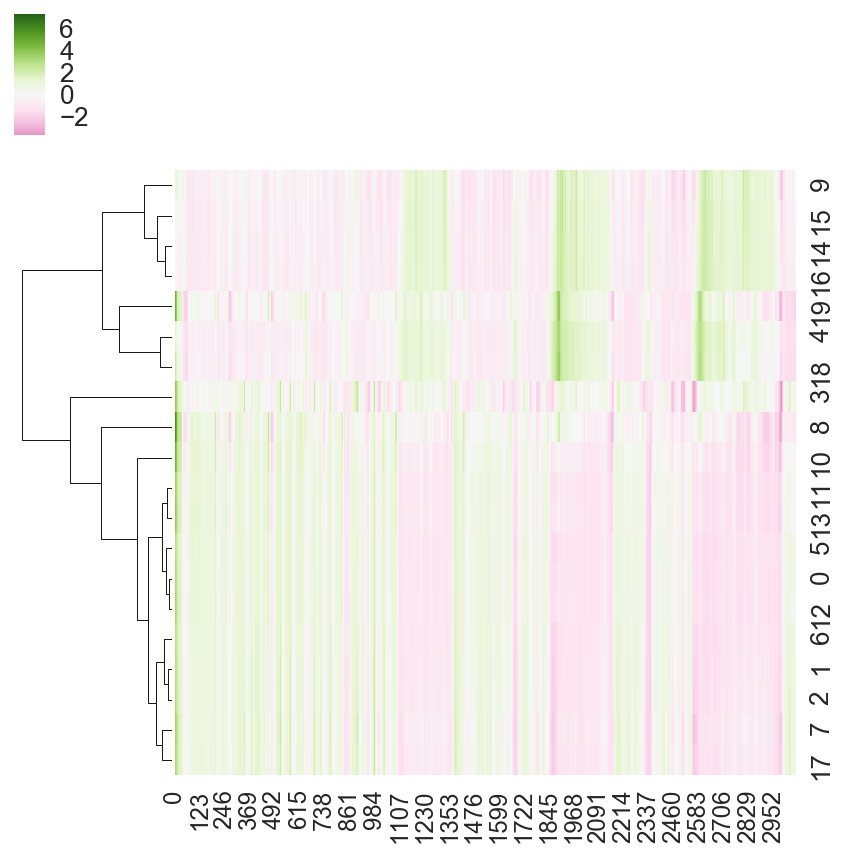

In [41]:
# Plot heat map of fluorescence centering the color bar at 0
# rows are neurons, but I can't label them.
sns.clustermap(data0.T, cmap='PiYG', center=0, col_cluster=False,
               figsize=(7,7))
# Rotate ticks
_ = plt.yticks(rotation=0)

plt.savefig('../output/raw_data_singleworm.pdf', bbox_inches='tight')

There is definitely interesting structure in this heat map. Let's try clustering the most related neurons using `seaborn` clustermap on the convariance matrix.

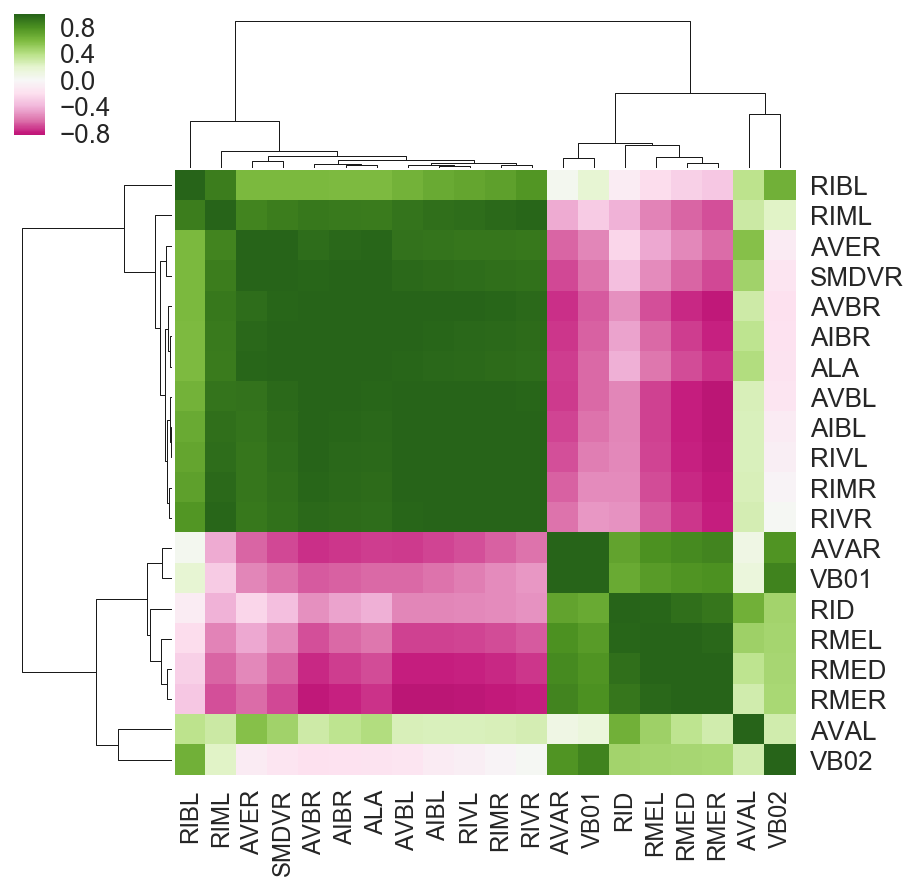

In [8]:
def plot_covariance_matrix(data, neuron_list, function=None, rotation=0, figsize=(7,7)):
    # Compute the covariance matrix
    covar = data.T.dot(data)/len(data)

    covar = pd.DataFrame(covar, columns=neuron_list,
                         index=neuron_list)
    cg = sns.clustermap(covar.as_matrix(), cmap="PiYG", figsize=figsize,
                        **{'center':0})
    temp = cg.ax_heatmap.get_xticklabels()

    # Generate dictionary to convert numerical label to neuron name
    if not function:
        neuron_dict = {i: neurons for i, neurons in enumerate(neuron_list)}
    else:
        neuron_dict = {i: function[neurons]
                   for i, neurons in enumerate(neuron_list)}

    # Extract labels from both axis
    xlabels = [item.get_text()
               for item in cg.ax_heatmap.xaxis.get_ticklabels()]
    ylabels = [item.get_text()
               for item in cg.ax_heatmap.yaxis.get_ticklabels()]

    # Map labels to neuron name given the dictionary
    cg.ax_heatmap.xaxis.set_ticklabels([neuron_dict[y] for y in
                                        [int(x) for x in xlabels]])
    cg.ax_heatmap.yaxis.set_ticklabels([neuron_dict[y] for y in
                                        [int(x) for x in ylabels]])

    # Rotate labels in x axis
    _ = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(),
                 rotation=90)
    _ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(),
                 rotation=rotation)
    
    return cg

plot_covariance_matrix(data0, neurons_with_replicates)

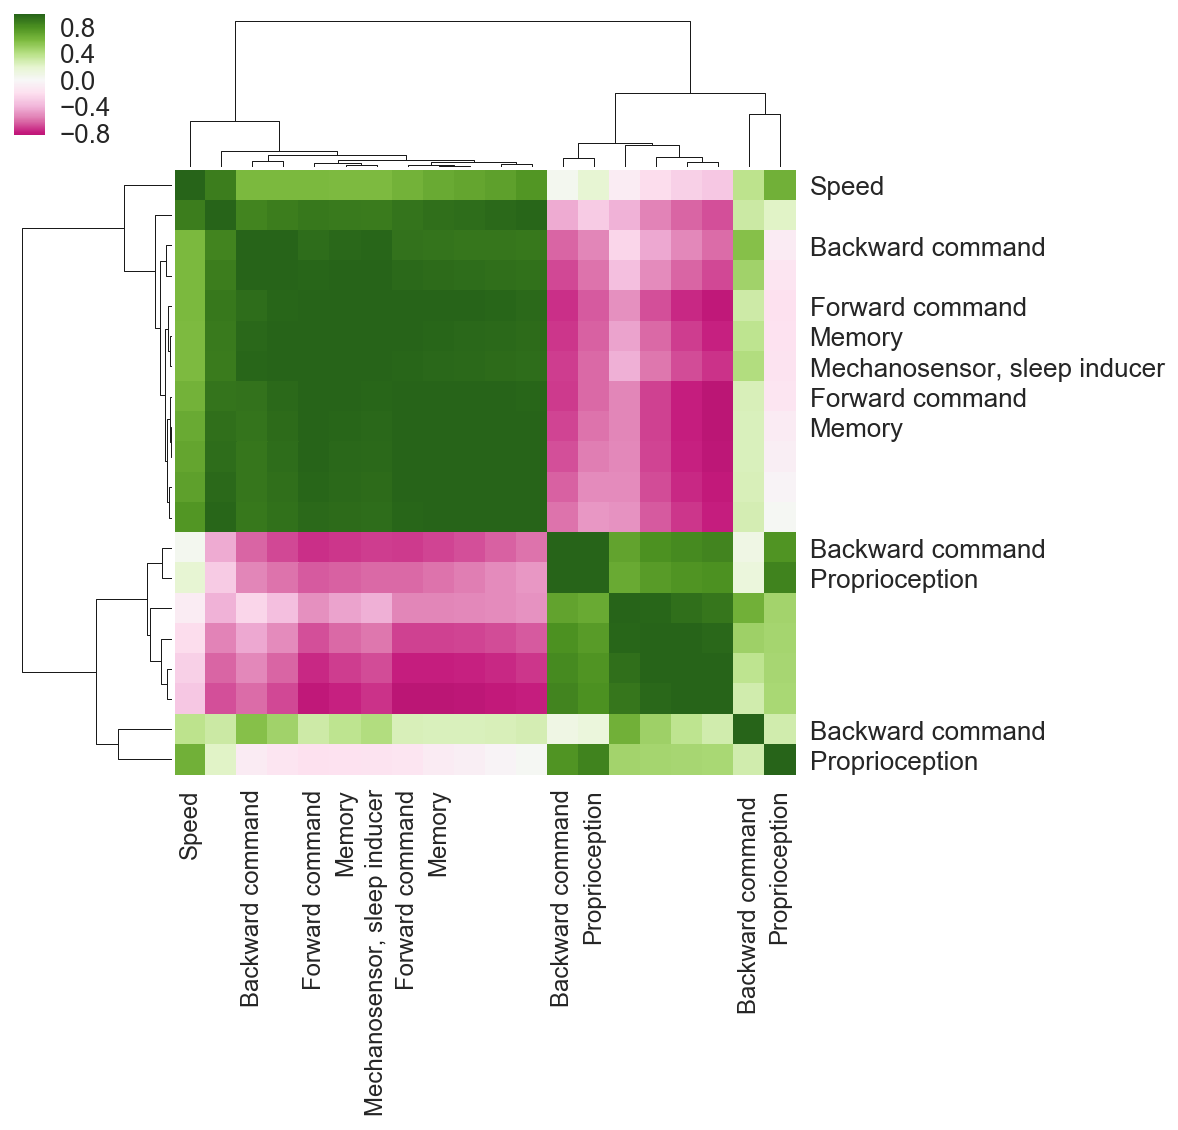

In [9]:
for neuron in df.neuron.unique():
    if neuron not in annotation_dict.keys():
        annotation_dict[neuron] = ''
plot_covariance_matrix(data0, neurons_with_replicates,
                       function=annotation_dict)

# Stimulated animals

In [10]:
# Extract data from animal index 0
neurons_in_stim = figure_out_neurons(df_stim,
                                     max_animals=len(df_stim.animal.unique()))
data_stim0 = get_data_from_worm(df_stim, 3, smooth=True,
                                neuron_list=neurons_in_stim)

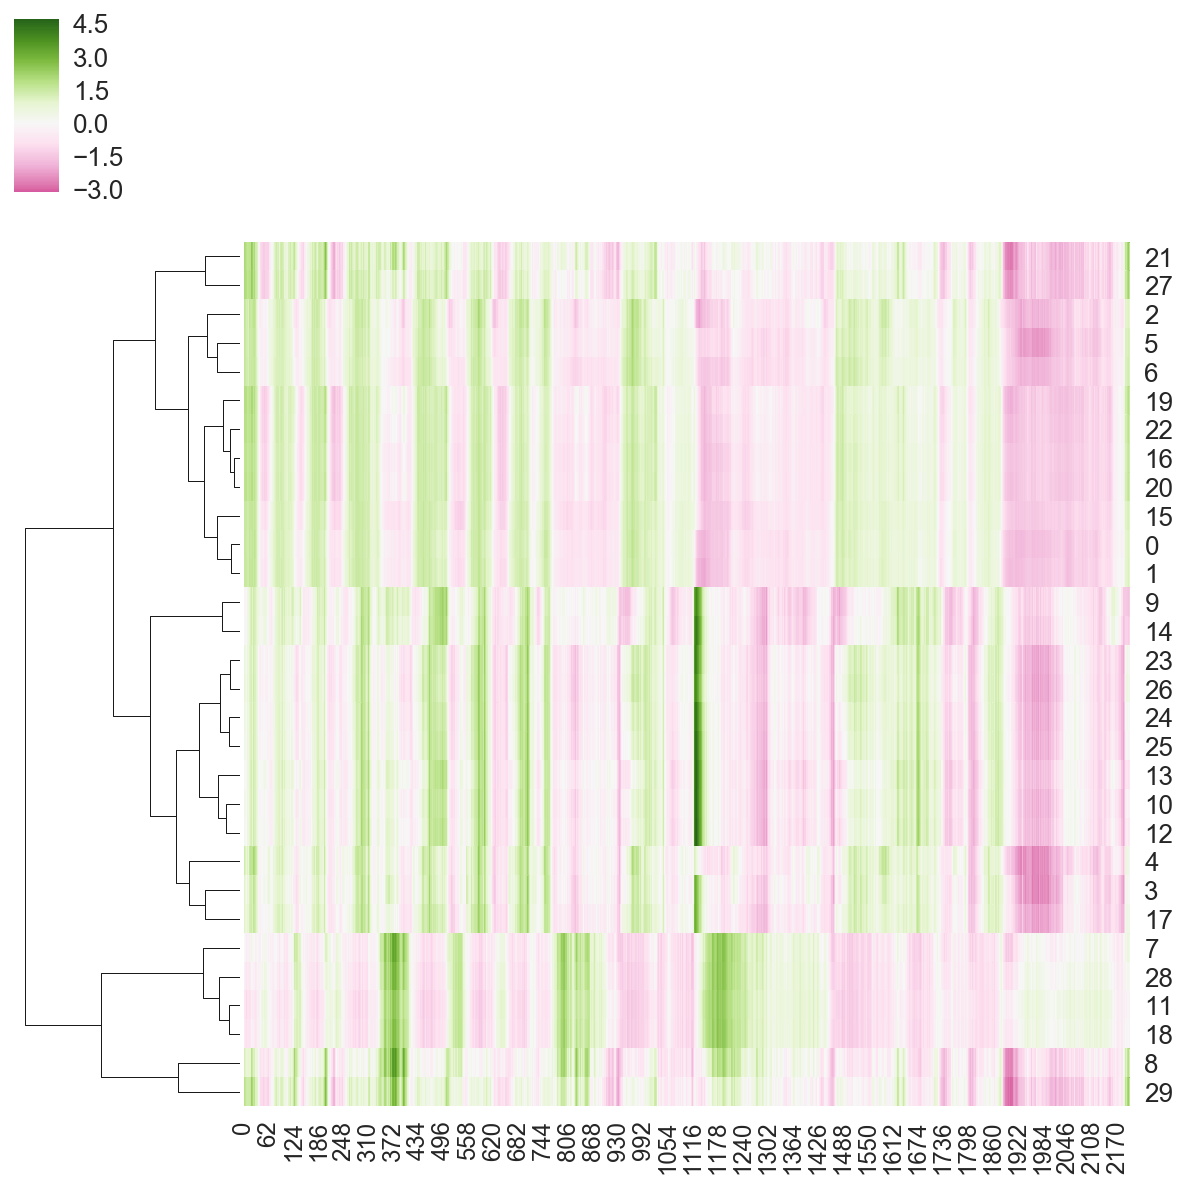

In [11]:
# Plot heat map of fluorescence centering the color bar at 0
sns.clustermap(data_stim0.T, cmap='PiYG', center=0,
               col_cluster=False, method='average')
# Rotate ticks
_ = plt.yticks(rotation=0)
# Label axis

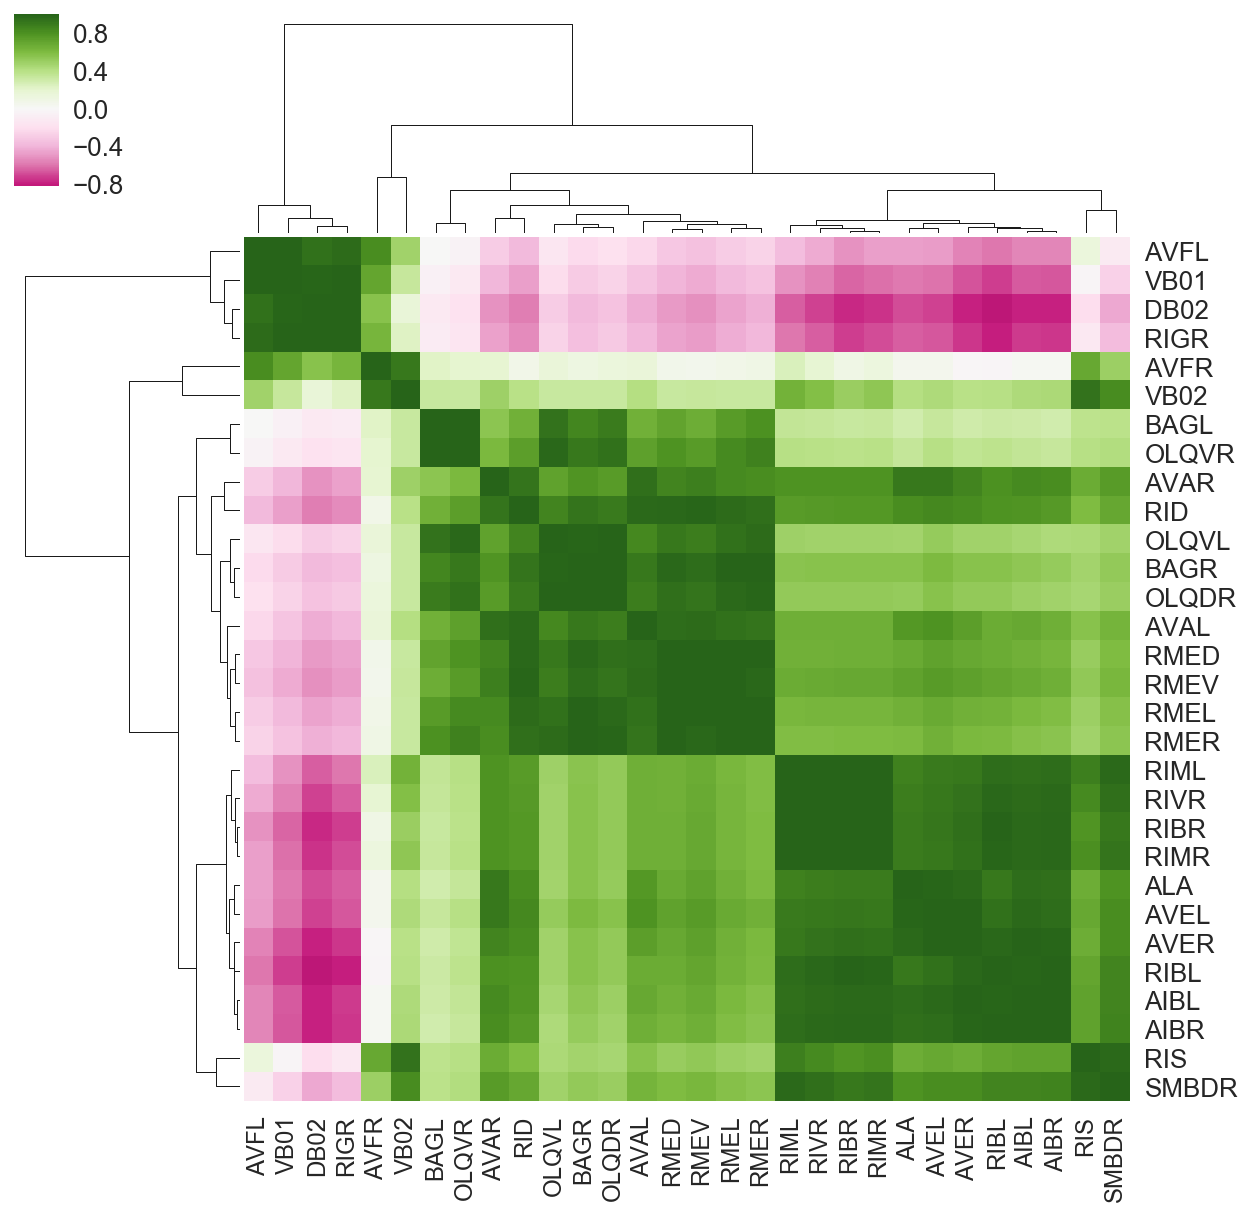

In [39]:
# Compute the covariance matrix
plot_covariance_matrix(data_stim0, neuron_list=neurons_in_stim, rotation=0, figsize=(10,10))

plt.savefig('../output/covariance_stim_single_worm.pdf', bbox_inches='tight')

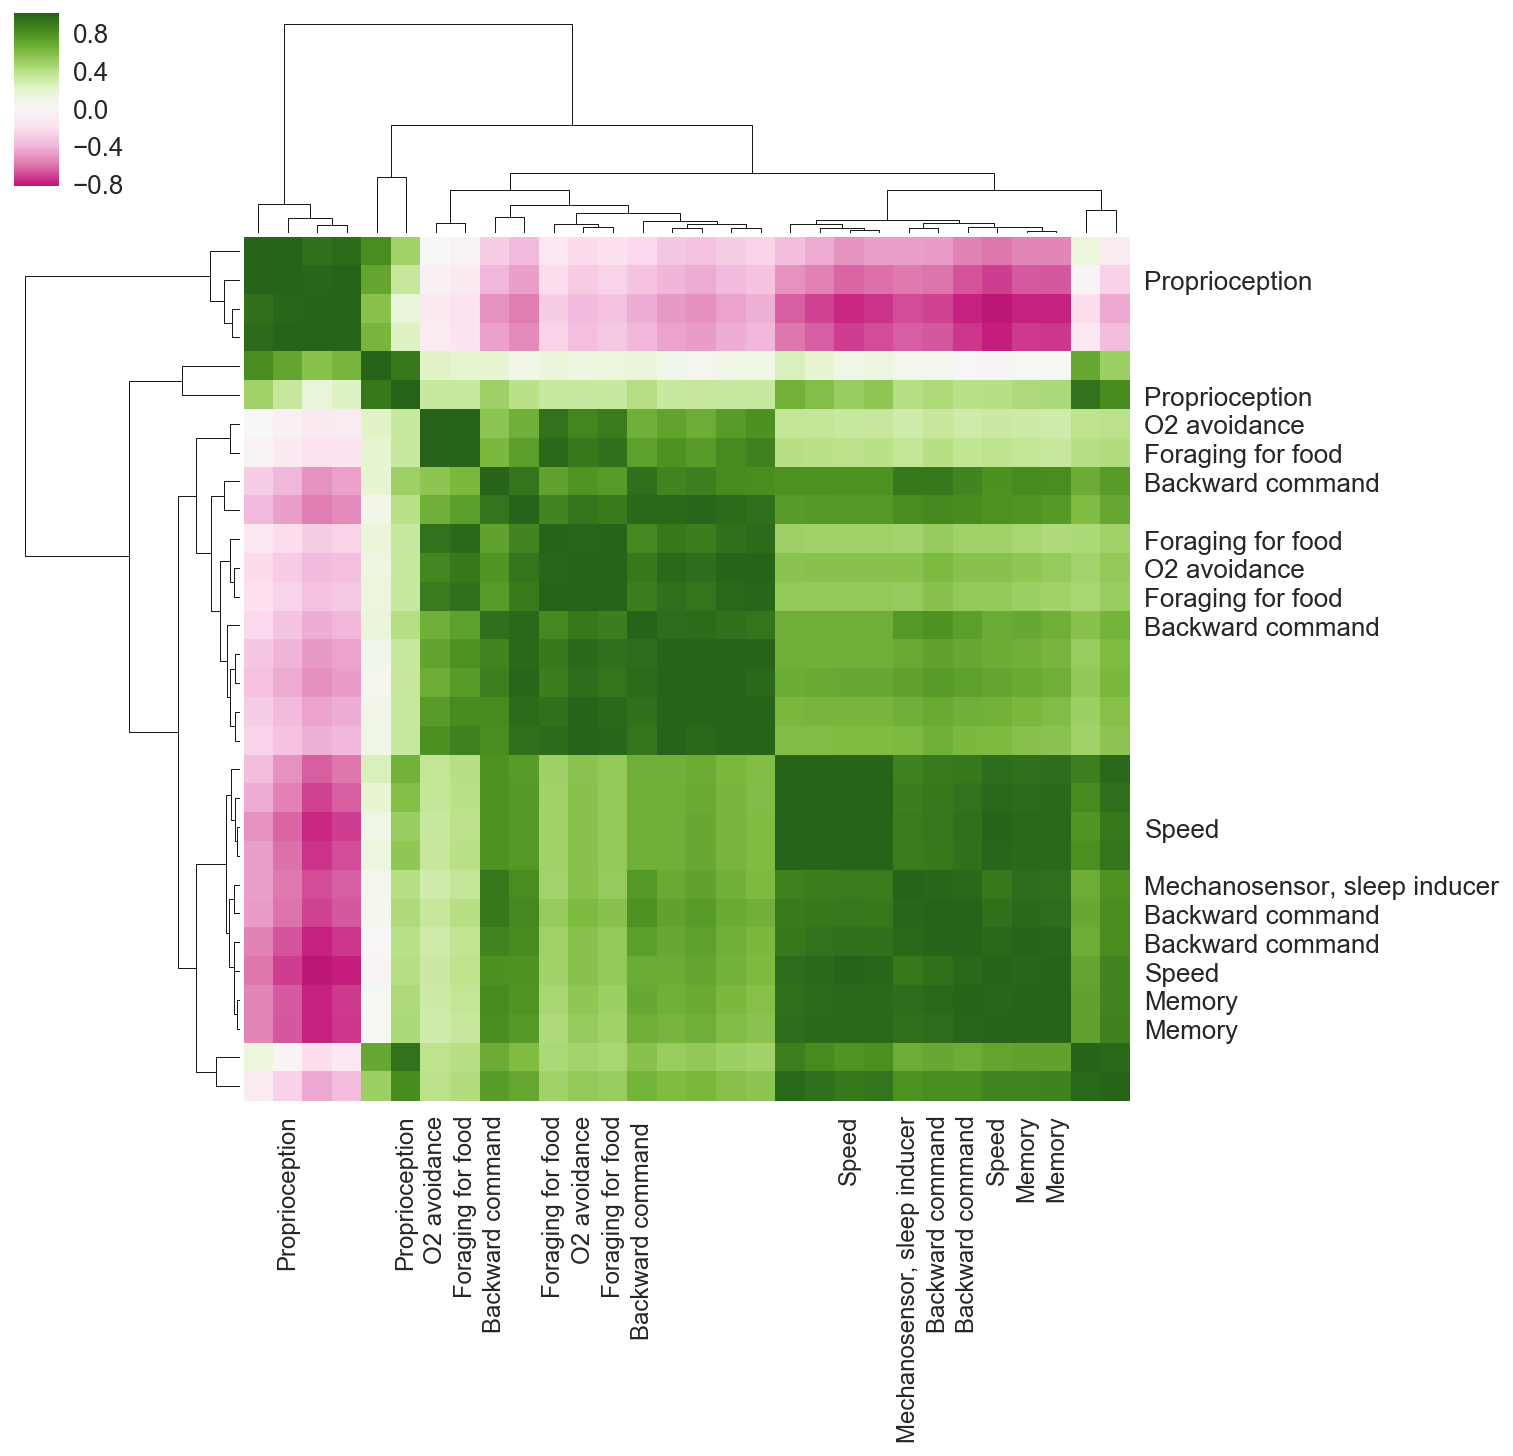

In [40]:
for neuron in df.neuron.unique():
    if neuron not in annotation_dict.keys():
        annotation_dict[neuron] = ''
plot_covariance_matrix(data_stim0, neurons_in_stim, function=annotation_dict, figsize=(10,10))

plt.savefig('../output/covariance_stim_single_worm_function_labels.pdf', bbox_inches='tight')

## Difference of Variances

In [14]:
neurons_in_all = figure_out_neurons(pd.concat([df, df_stim]), max_animals=6)
n = len(neurons_in_all)

def get_normalized_mean_covariance(df, neurons=neurons_in_all):
    n = len(neurons)
    mean_covar = np.zeros((n, n))
    for animal in df.animal.unique():
        data = get_data_from_worm(df, animal, neuron_list=neurons)
        mean_covar += data.T.dot(data)/len(data)
    return mean_covar/len(df.animal.unique())

mean_covar_nostim = get_normalized_mean_covariance(df)
mean_covar_stim = get_normalized_mean_covariance(df_stim)

# normalize covariance matrix:
# np.tile(np.diag(mean_covar_nostim), (1, mean_covar_nostim.shape[0]))

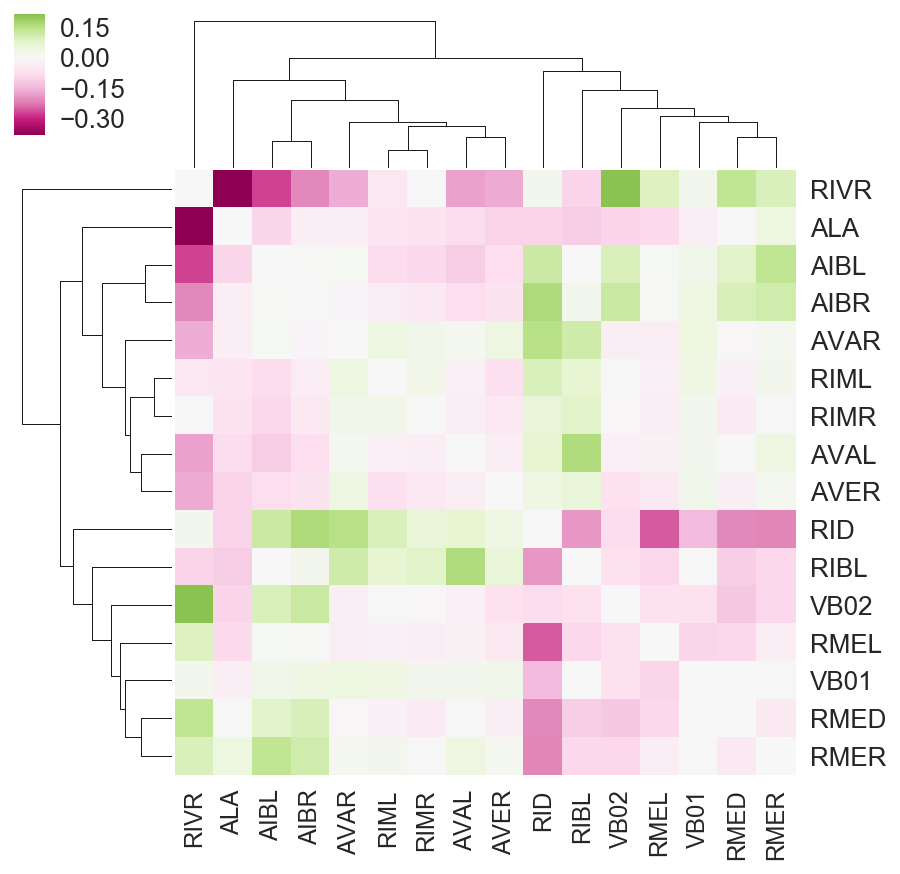

In [15]:
delta = mean_covar_stim - mean_covar_nostim
cg = sns.clustermap(delta, cmap="PiYG", figsize=(7, 7),
                    **{'center':0})
temp = cg.ax_heatmap.get_xticklabels()

# Generate dictionary to convert numerical label to neuron name
neuron_dict = {i: neurons for i, neurons in enumerate(neurons_in_all)}

# Extract labels from both axis
xlabels = [item.get_text() for item in cg.ax_heatmap.xaxis.get_ticklabels()]
ylabels = [item.get_text() for item in cg.ax_heatmap.yaxis.get_ticklabels()]

# Map labels to neuron name given the dictionary
cg.ax_heatmap.xaxis.set_ticklabels([neuron_dict[y] for y in
                                    [int(x) for x in xlabels]])
cg.ax_heatmap.yaxis.set_ticklabels([neuron_dict[y] for y in
                                    [int(x) for x in ylabels]])

# Rotate labels in x axis
_ = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

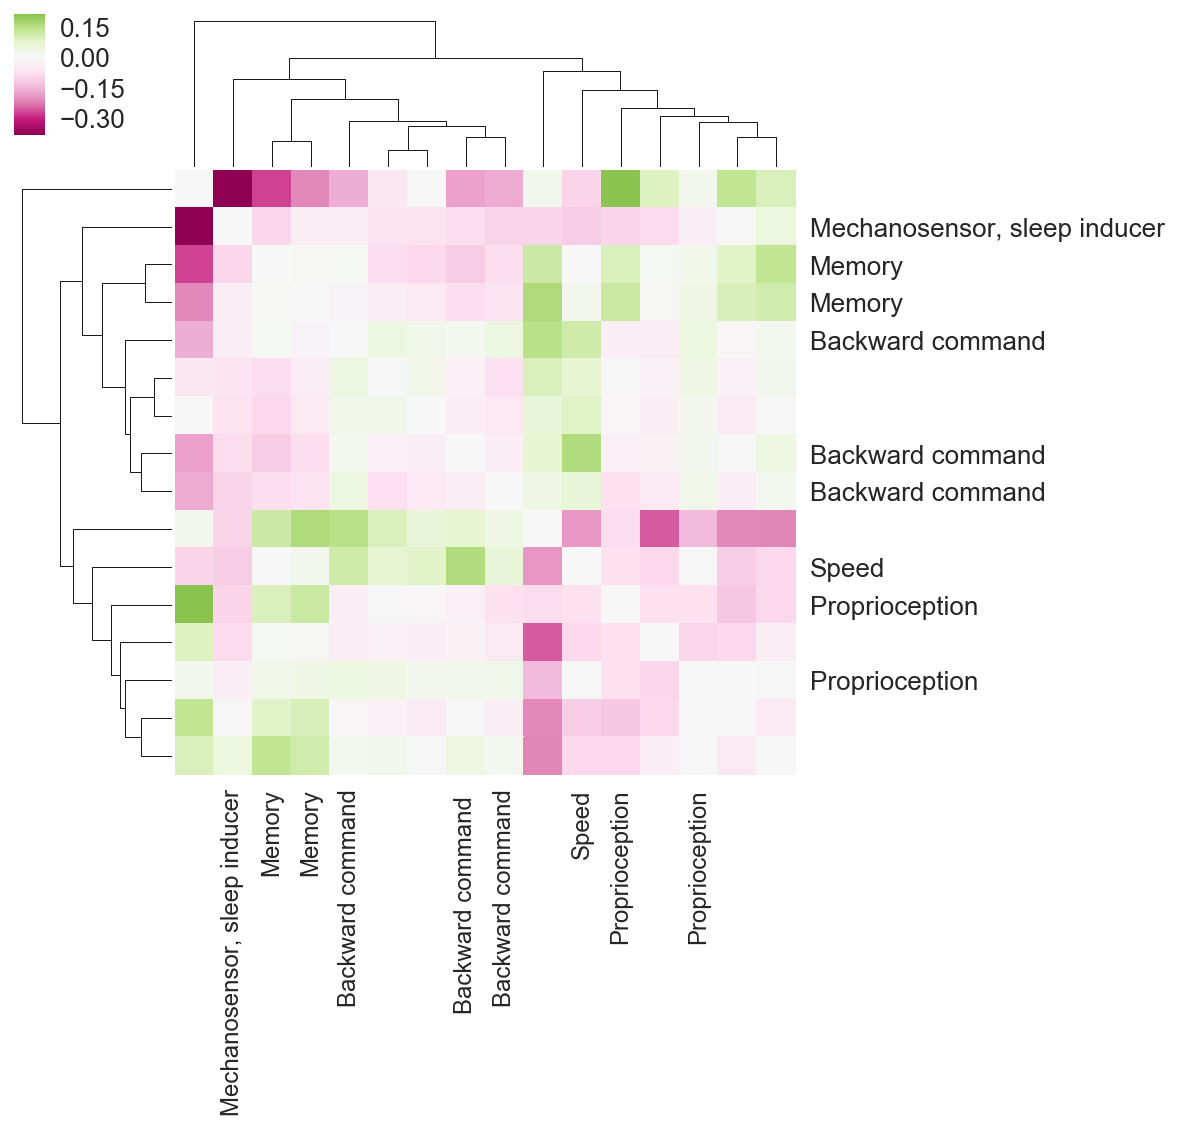

In [16]:
delta = mean_covar_stim - mean_covar_nostim
cg = sns.clustermap(delta, cmap="PiYG", figsize=(7, 7),
                    **{'center':0})
temp = cg.ax_heatmap.get_xticklabels()

# Generate dictionary to convert numerical label to neuron name
neuron_dict = {i: neurons for i, neurons in enumerate(neurons_in_all)}

# Extract labels from both axis
xlabels = [item.get_text() for item in cg.ax_heatmap.xaxis.get_ticklabels()]
ylabels = [item.get_text() for item in cg.ax_heatmap.yaxis.get_ticklabels()]

# Map labels to neuron name given the dictionary
cg.ax_heatmap.xaxis.set_ticklabels([annotation_dict[neuron_dict[y]] for y in
                                    [int(x) for x in xlabels]])
cg.ax_heatmap.yaxis.set_ticklabels([annotation_dict[neuron_dict[y]] for y in
                                    [int(x) for x in ylabels]])

# Rotate labels in x axis
_ = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

## PCA

In [17]:
df_subset = df[df.neuron.isin(neurons_in_all)].copy()
df_subset_stim = df_stim[df_stim.neuron.isin(neurons_in_all)].copy()

subset1 = get_data_from_worm(df_subset, 1)
subset2 = get_data_from_worm(df_subset, 2)
subset0 = get_data_from_worm(df_subset, 0)


stim_subset1 = get_data_from_worm(df_subset_stim, 4)
stim_subset2 = get_data_from_worm(df_subset_stim, 5)
stim_subset0 = get_data_from_worm(df_subset_stim, 3)

pca = PCA(3)
pca.fit(subset0)
print(pca.explained_variance_ratio_)
W = pca.components_

[0.70718037 0.0732892  0.0693338 ]


In [18]:
tD0 = W.dot(subset0.T)
tD1 = W.dot(subset1.T)
tD2 = W.dot(subset2.T)

stim_tD0 = W.dot(stim_subset0.T)
stim_tD1 = W.dot(stim_subset1.T)
stim_tD2 = W.dot(stim_subset2.T)

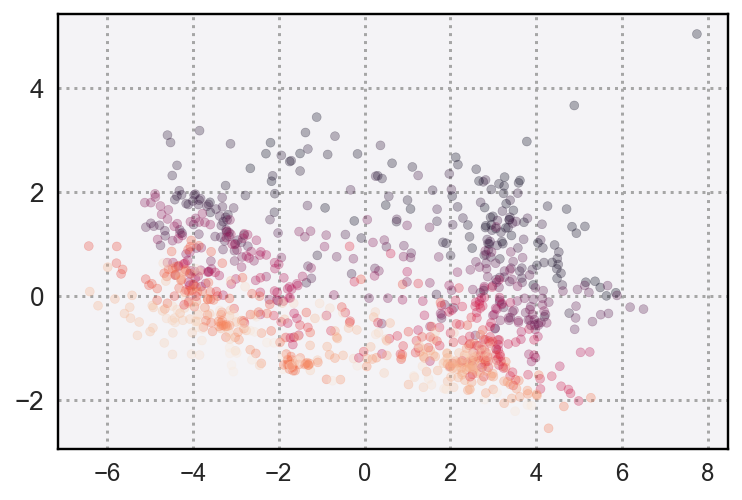

In [19]:
subsample = 10
color = np.linspace(0, 1, len(tD0[0, ::subsample]))
color1 = np.linspace(0, 1, len(tD1[0, ::subsample]))
color2 = np.linspace(0, 1, len(tD2[0, ::subsample]))

plt.scatter(tD0[0, ::subsample], tD0[1, ::subsample],
            s=20, alpha=0.3, c=color)
plt.scatter(tD1[0, ::subsample], tD1[1, ::subsample],
            s=20, alpha=0.3, c=color1)
plt.scatter(tD2[0, ::subsample], tD2[1, ::subsample],
            s=20, alpha=0.3, c=color2)

## 3D trajectories

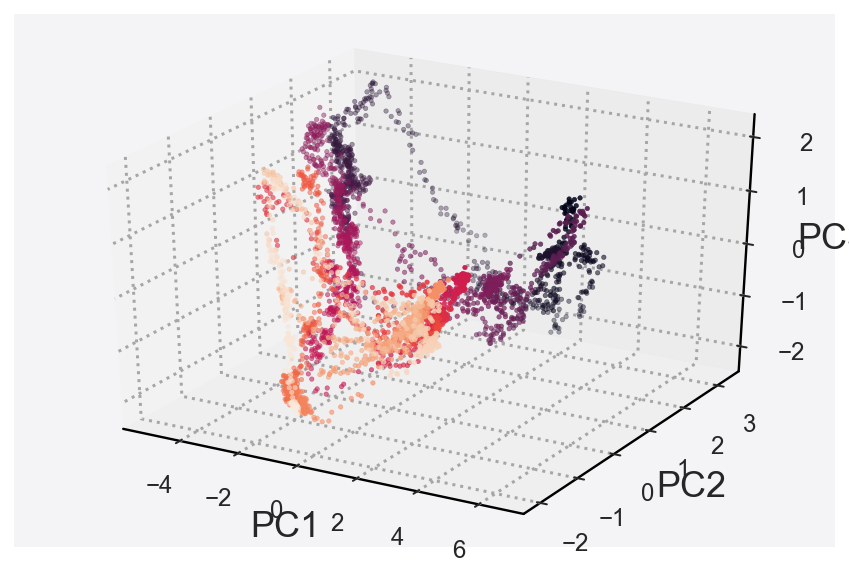

In [37]:
def plot3d(tD, ax=None, color='k', subsample=5, **kwargs):
    tD = tD[:, ::subsample]
#     color = tD[0, ::subsample]
    color = np.linspace(0, 1, len(tD[0]))
    x = tD[0, :]
    y = tD[1, :]
    z = tD[2, :]
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, zdir='z',  c=color, **kwargs)
    else:
        ax.scatter(x, y, z, zdir='z',  c=color, **kwargs)
    return ax

# ax = plot3d(tD1, ax=None, color=color, subsample=1, s=5)
ax = plot3d(tD2, ax=None, color=color, subsample=1, s=5)
# ax = plot3d(tD0, ax=None, color=color, subsample=1, s=5)

plt.xlabel('PC1')
plt.ylabel('PC2')
ax.set_zlabel('PC3')

plt.tight_layout()
plt.savefig('../output/pca_3d.pdf', bbox_inches='tight')

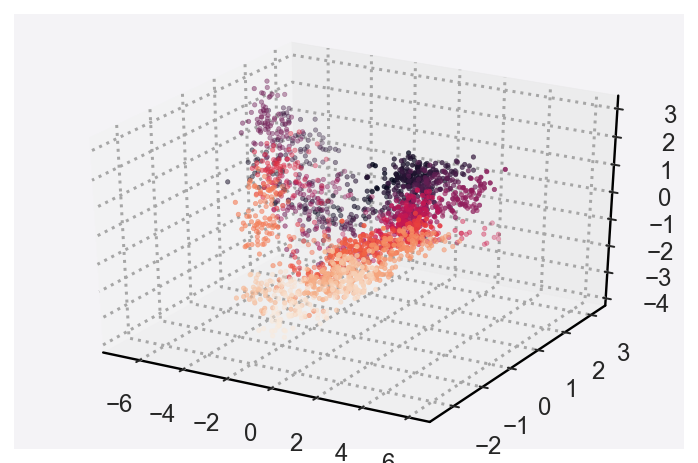

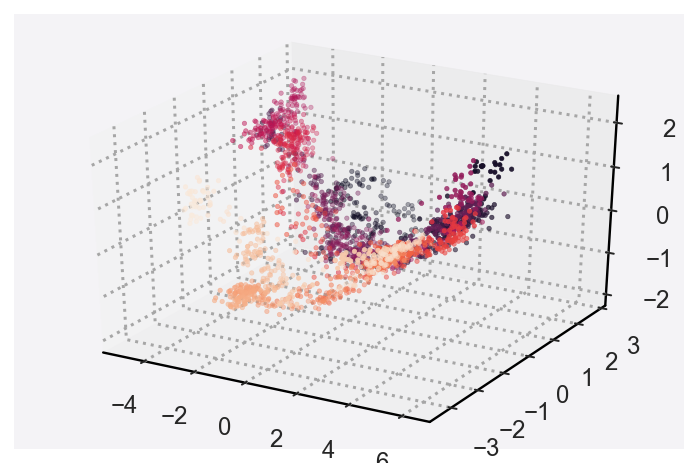

In [21]:
ax = plot3d(stim_tD1, ax=None, color=color, subsample=1, s=5)
ax = plot3d(stim_tD2, ax=None, color=color, subsample=1, s=5)


# Plotting the covariance of two neurons through time.

As an exercise, I took neurons for which we know their functions, and plotted them together, to see whether they do the same thing. Sometimes they do!

Backward command


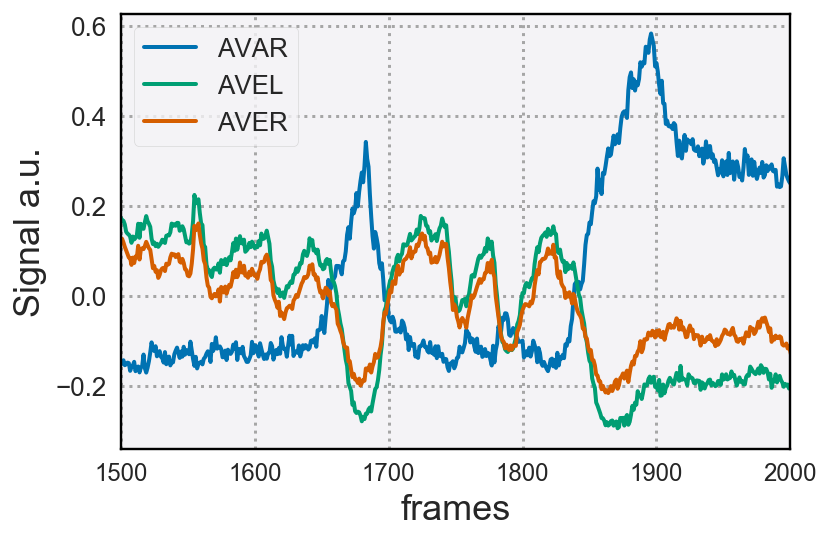

In [33]:
for name, group in df.groupby(['function', 'animal']):
    if name[1] != 0:
        continue
    print(name[0])
    for neuron, group2 in group.groupby('neuron'):
        plt.plot(group2.frame, group2.smooth_fluor,
                 label=neuron)
    break
plt.legend()

plt.xlim(1500, 2000)

plt.xlabel('frames')
plt.ylabel('Signal a.u.')
plt.savefig('../output/cov_thru_time.pdf')

# Fit a Hidden Markov Model to identify transitions

Next, we would like to fit the first principal component to an HMM to identify transition states. 

In [23]:
# Use a Gaussian HMM to identify the number of spaces and transitions that occur
model = hmm.GaussianHMM(n_components=2, covariance_type="full",
                        n_iter=100, algorithm='map')

# Fit the data. The data has to be reshaped so that it looks like
# [[t0], [t1], ...] <--- HMM calls this a 1D array.
model.fit(tD0[0, :].reshape(-1, 1))

/Users/dangeles/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/dangeles/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/dangeles/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/dangeles/anaconda3/lib/python3.5/s

GaussianHMM(algorithm='map', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=2, n_iter=100, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [24]:
model.transmat_

array([[0.99641649, 0.00358351],
       [0.00635341, 0.99364659]])

In [25]:
model.means_

array([[ 2.34779353],
       [-4.16466342]])